In [1]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Model
from keras.layers import LSTM, Dense, Embedding, Input, concatenate
from keras.utils.np_utils import to_categorical
import numpy as np


In [2]:
data = pd.read_csv("./data/spotify_songs_processed.csv")
data = data[['playlist_name', 'playlist_name_sentiment']]
data['playlist_name_sentiment'] = (data['playlist_name_sentiment'] - data['playlist_name_sentiment'].min()) / (data['playlist_name_sentiment'].max() - data['playlist_name_sentiment'].min())


In [3]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['playlist_name'])
sequences = tokenizer.texts_to_sequences(data['playlist_name'])

max_sequence_length = max([len(seq) for seq in sequences])
sequences_padded = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')


In [4]:
vocab_size = len(tokenizer.word_index) + 1 
input_text = Input(shape=(max_sequence_length,))
input_sentiment = Input(shape=(1,))

embedding = Embedding(vocab_size, 50, input_length=max_sequence_length)(input_text)
lstm = LSTM(50, return_sequences=False)(embedding)

In [5]:
sentiment_dense = Dense(50, activation='relu')(input_sentiment)

concat = concatenate([lstm, sentiment_dense])
output = Dense(vocab_size, activation='softmax')(concat)

model = Model(inputs=[input_text, input_sentiment], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 20, 50)       29100       ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 50)           20200       ['embedding[0][0]']              
                                                                                              

In [6]:
X_train = []
y_train = []
for sequence in sequences_padded:
    for i in range(1, len(sequence)):
        X_train.append(sequence[:i])
        y_train.append(sequence[i])

X_train_padded = pad_sequences(X_train, maxlen=max_sequence_length, padding='post')
y_train = np.array(y_train)
y_train_one_hot = to_categorical(y_train, num_classes=vocab_size)


In [9]:
sentiment_data = []
for idx, sequence in enumerate(sequences_padded):
    sentiment_value = data['playlist_name_sentiment'].iloc[idx]
    for i in range(1, len(sequence)):
        sentiment_data.append(sentiment_value)

sentiment_data = np.array(sentiment_data)

if len(data['playlist_name_sentiment']) >= len(X_train_padded):
    sentiment_data = data['playlist_name_sentiment'].iloc[:len(X_train_padded)]
else:
    print("Error: Desajuste en la longitud de los datos de sentimiento.")


Error: Desajuste en la longitud de los datos de sentimiento.


In [10]:
history = model.fit([X_train_padded, sentiment_data], y_train_one_hot, epochs=100, batch_size=128, validation_split=0.2)


Epoch 1/100
1830/1830 [==============================] - 43s 22ms/step - loss: 1.3884 - accuracy: 0.8311 - val_loss: 1.2674 - val_accuracy: 0.8366
Epoch 2/100
1830/1830 [==============================] - 43s 24ms/step - loss: 1.0242 - accuracy: 0.8398 - val_loss: 0.8104 - val_accuracy: 0.8542
Epoch 3/100
1830/1830 [==============================] - 42s 23ms/step - loss: 0.7167 - accuracy: 0.8604 - val_loss: 0.6343 - val_accuracy: 0.8706
Epoch 4/100
1830/1830 [==============================] - 41s 22ms/step - loss: 0.5581 - accuracy: 0.8829 - val_loss: 0.5108 - val_accuracy: 0.8951
Epoch 5/100
1830/1830 [==============================] - 41s 23ms/step - loss: 0.4354 - accuracy: 0.9036 - val_loss: 0.3868 - val_accuracy: 0.9143
Epoch 6/100
1830/1830 [==============================] - 42s 23ms/step - loss: 0.3589 - accuracy: 0.9179 - val_loss: 0.3232 - val_accuracy: 0.9307
Epoch 7/100
1830/1830 [==============================] - 44s 24ms/step - loss: 0.3096 - accuracy: 0.9292 - val_loss: 0

NameError: name 'history' is not defined

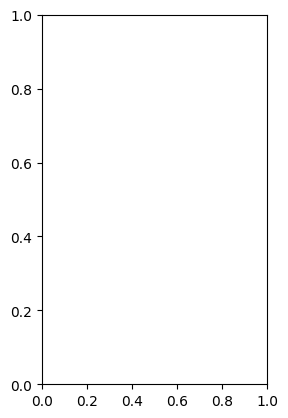

In [1]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [11]:
model.save('title_builder.h5')


In [12]:
import pickle

with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file, protocol=pickle.HIGHEST_PROTOCOL)
